In [2]:
import numpy as np
from numpy.fft import *
from scipy.io import loadmat
from scipy.linalg import dft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

C=loadmat('Lab_data/S.mat')['S']
m=loadmat('Lab_data/M.mat')['M']

(a) Determine and depict m, Ci,i = 1,2,...,Nc and mi,i = 1,2,...,Nc. What can you say about the configuration of the coils?

In [3]:
Nc=8
M=np.reshape(np.repeat(m,Nc,axis=1),C.shape)*C

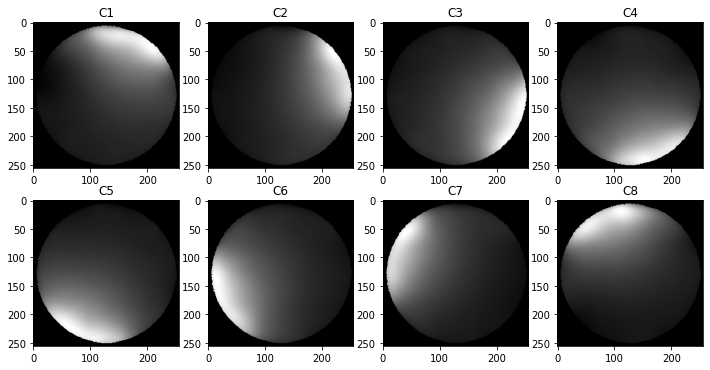

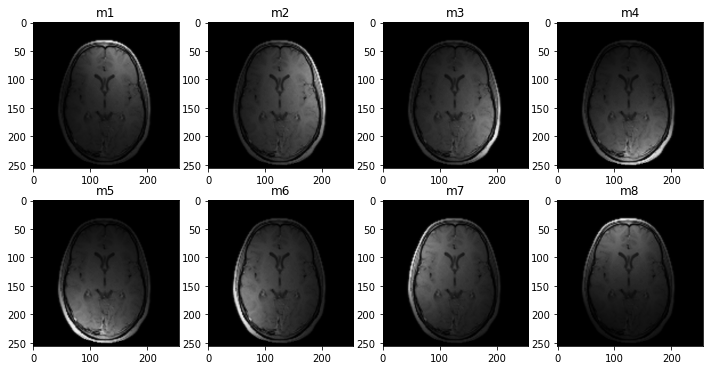

In [4]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.abs(C[:,:,i]),cmap='gray')
    plt.title('C'+str(i+1))
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.abs(M[:,:,i]),cmap='gray')
    plt.title('m'+str(i+1))

(b) Employ the root-sum-of-square approach and the weighted coil sensitivity approach to combine the data from the individual coils. Depict and compare the combined images with respect to the original fully sample image m.

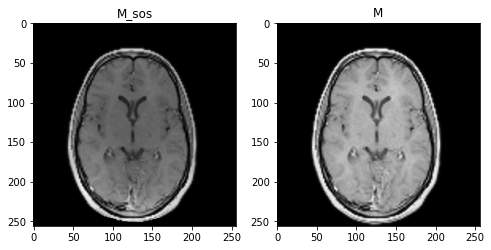

In [5]:
M_sos=np.sqrt(np.sum(M*M.conj(),axis=2))
# M_sos=np.sqrt(np.sum(np.abs(M)**2,axis=2))
# M_sos=np.sum(M*M.conj(),axis=2)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.abs(M_sos),cmap='gray')
plt.title('M_sos')
plt.subplot(1,2,2)
plt.imshow(np.abs(m),cmap='gray')
plt.title('M')
plt.show()

(c) Generate 2 uniform undersampling patterns with acceleration factors of 4 and 8 (U4 and U8) and 2 random undersampling patterns (UR4 and UR8). Undersampling should be performed along the horizontal direction. Each sampling pattern must be a matrix with 1s in the sampled positions and 0s in the remaining entries.

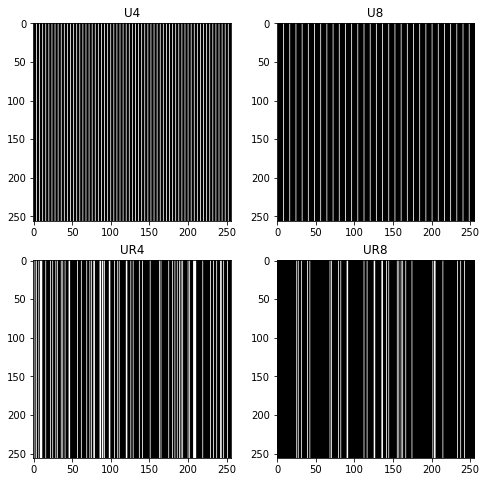

In [6]:
U4=np.zeros_like(C)
U8=np.zeros_like(C)
UR4=np.zeros_like(C)
UR8=np.zeros_like(C)
U4[:,np.arange(0,256,4,dtype=int),:]=1
U8[:,np.arange(0,256,8,dtype=int),:]=1
UR4[:,np.random.choice(256,256//4,replace=False)]=1
UR8[:,np.random.choice(256,256//8,replace=False)]=1

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(np.abs(U4)[:,:,0],cmap='gray')
plt.title('U4')
plt.subplot(2,2,2)
plt.imshow(np.abs(U8)[:,:,0],cmap='gray')
plt.title('U8')
plt.subplot(2,2,3)
plt.imshow(np.abs(UR4)[:,:,0],cmap='gray')
plt.title('UR4')
plt.subplot(2,2,4)
plt.imshow(np.abs(UR8)[:,:,0],cmap='gray')
plt.title('UR8')
plt.show()

(d) Obtain the aliased images for each coil as a result of undersampling with the generated patterns. For this you should use:
$$b_i=F^{-1}UFC_im$$
where U is the corresponding undersampling pattern, F is the Fourier transform and bi are the aliased images for each coil i = 1,...,Nc. Depict and compare the aliased images for the different undersampling factors and patterns.

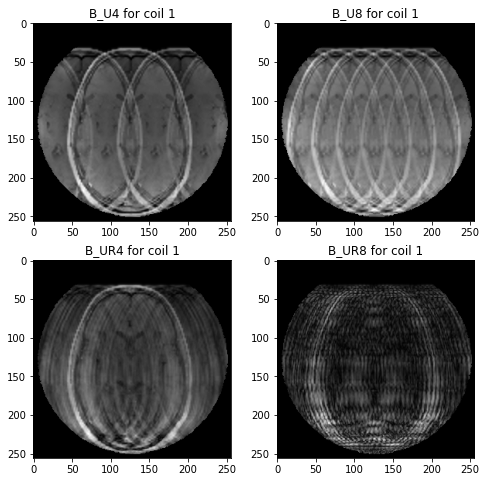

In [7]:
def Undersample(M,U):
    return fftshift(ifft2(U*fft2(ifftshift(M),axes=(0,1)),axes=(0,1)))

B_U4=Undersample(M,U4)
B_U8=Undersample(M,U8)
B_UR4=Undersample(M,UR4)
B_UR8=Undersample(M,UR8)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(np.abs(np.sum(B_U4*C.conj(),axis=2)),cmap='gray')
plt.title('B_U4 for coil 1')
plt.subplot(2,2,2)
plt.imshow(np.abs(np.sum(B_U8*C.conj(),axis=2)),cmap='gray')
plt.title('B_U8 for coil 1')
plt.subplot(2,2,3)
plt.imshow(np.abs(np.sum(B_UR4*C.conj(),axis=2)),cmap='gray')
plt.title('B_UR4 for coil 1')
plt.subplot(2,2,4)
plt.imshow(np.abs(np.sum(B_UR8*C.conj(),axis=2)),cmap='gray')
plt.title('B_UR8 for coil 1')
plt.show()


(e) The SENSE undersampled reconstruction can be written as a linear problem:
$$E\hat{M}=b$$
where $\hat{M}$ is the image to be reconstructed and the encoding matrix $E = UFC$ corresponds to the forward sampling operator, similar to what was described in d, with U the undersampling operator, F the Fourier transform operator, C the coil sensitivity maps and b the undersampled k-space data.

$$b=EM$$
$$M=E^Hb$$

The forward operator E represents the k-space acquisition (i.e. going from image space to k-space). The conjugate transpose operator EH represents the image reconstruction (i.e. going from k-space to image space).

To test this class, generate a uniform undersampling pattern of 4 U4 and create an instance of the corresponding encoding operator. Simulate the acquisition on image M with the forward operator to obtain b. Following, perform a zero-fill reconstruction using the conjugate transpose operator to obtain m. Depict and comment on the zero-fill reconstruction.

/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


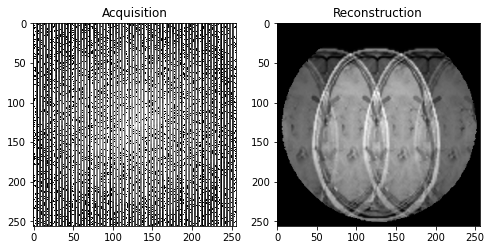

In [8]:
def E(U,C,m):
    coil_rss=np.sqrt(np.sum(C*C.conj(),axis=2))#+1e-12
    # return U*fftshift(fft2(ifftshift(np.reshape(np.repeat(m,Nc,axis=1),C.shape)*C),axes=(0,1)))
    m=m/coil_rss
    m[np.isnan(m)]=0
    m[np.isinf(m)]=0
    return U*fftshift(fft2(ifftshift(np.reshape(np.repeat(m,Nc,axis=1),C.shape)*C),axes=(0,1)))
def EH(C,b):
    coil_rss=np.sqrt(np.sum(C*C.conj(),axis=2))#+1e-12
    # return np.sum(fftshift(ifft2(ifftshift(b),axes=(0,1))),axis=2)
    res=np.sum(fftshift(ifft2(ifftshift(b),axes=(0,1)))*C.conj(),axis=2)/coil_rss
    res[np.isnan(res)]=0
    res[np.isinf(res)]=0
    return res
# Acquisition
b=E(U4,C,m)

# Reconstruction
M_recon=EH(C,b)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.abs(b[:,:,0]),cmap='gray',norm=LogNorm())
plt.title('Acquisition')
plt.subplot(1,2,2)
plt.imshow(np.abs(M_recon),cmap='gray')
plt.title('Reconstruction')
plt.show()

(f) Iterative SENSE reconstruction is obtained by solving the linear problem $E\hat{m}=b$ as a least square minimization $\min_m\|(E^HE)m-b\|_2^2$. Implement the Gradient Descent method to
solve the equivalent normal equation:
$$\min_m\|(E^HE)m-E^Hb\|_2^2$$
To do this, you can use the forward E and conjugate transpose EH encoding operators you implemented in e. Your function for the Gradient Descent should be in the following syntax:
```python
def Gradient_Descent(b,maxit):
    ...
    return rho
```
where b is the k-space data, E is the encoding operator and maxit is the maximum number of iterations. You can use the following Gradient Descent algorithm:
$$m_0=E^Hb$$
$$r_0=m_0-E^HEm_0$$
$$\alpha_k=\cfrac{r_k^Tr_k}{r_k^TE^HEr_k}$$
$$m_{k+1}=m_k+\alpha_kr_k$$
$$r_{k+1}=r_k-\alpha_kE^HEr_k$$
Show and compare your results for the undersampling patterns generated in question c. What can you conclude from them? How many iterations are needed to reconstruct acquisitions with the different sampling patterns?

In [10]:
def Gradient_Descent(U,C,b,maxit):
    m_=EH(C,b)
    r=m_-EH(C,E(U,C,m_))
    for i in tqdm(range(maxit)):
        # plt.imshow(np.abs(r),cmap='gray',norm=LogNorm())
        a=np.abs(np.sum(r.T*r)/np.sum(r.T*EH(C,E(U,C,r))))
        # print(a)
        m_+=a*r
        r-=a*EH(C,E(U,C,r))
        err=np.sum(np.abs(r))
        if err<1e-2:
            print('Converged at',i,'with error',err)
            break
    plt.show()
    return m_

b4=E(U4,C,m)
m_U4=Gradient_Descent(U4,C,b4,1000)
# b8=E(U8,C,m)
# m_U8=Gradient_Descent(U8,C,b8,1000)
# bR4=E(UR4,C,m)
# m_UR4=Gradient_Descent(UR4,C,bR4,1000)
# bR8=E(UR8,C,m)
# m_UR8=Gradient_Descent(UR8,C,bR8,1000)

# plt.figure(figsize=(8,8))
# plt.subplot(2,2,1)
# plt.imshow(np.abs(m_U4),cmap='gray')
# plt.title('m_U4')
# plt.subplot(2,2,2)
# plt.imshow(np.abs(m_U8),cmap='gray')
# plt.title('m_U8')
# plt.subplot(2,2,3)
# plt.imshow(np.abs(m_UR4),cmap='gray')
# plt.title('m_UR4')
# plt.subplot(2,2,4)
# plt.imshow(np.abs(m_UR8),cmap='gray')
# plt.title('m_UR8')
# plt.show()

/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
 13%|█▎        | 130/1000 [00:15<01:42,  8.46it/s]

Converged at 130 with error 0.008445734983858333


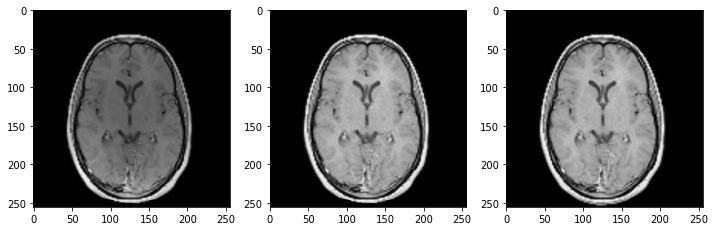

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.abs(M_sos),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(m_U4),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.abs(m),cmap='gray')
plt.show()

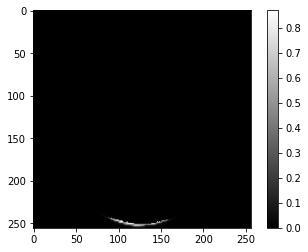

In [13]:
plt.imshow(np.abs(m)-np.abs(m_U4),cmap='gray')
plt.colorbar()
plt.show()